## Final solution - 0.553 on private leaderboard (39 place out of 3497 participants).  Big respect to my teammates - [Tatiana Glazkova](https://www.linkedin.com/in/glazkovads/) and [Andrew Ponomarev](https://www.linkedin.com/in/andrew-ponomarev-ba361954/).


Блокнот, подводящий промежуточные итоги по подготовке данных: чистка, извлечение признаков, создание новых признаков. Предполагается, что этот блокнот будет в дальнейшем использоваться как база для исследования и сравнения различных алгоритмов машинного обучения, генерации мета-признаков и пр.

В основе заготовки - популярное решение по обработке лога от Hosseinali (и немного от Andrew Lukyanenko). К нему добавлено:

- чистка данных (удаление сессий с малым числом событий, сокращение сессий с перерывами и пр.)
- новые признаки (свойства по различным топикам, временным промежуткам, успешность в играх и пр.)
- решена проблема с невоспроизводимостью предварительной обработки данных
- включает решение 557 (https://www.kaggle.com/panikads/data-processing-consolidated-376397 - версия 2)
- включает результат рекурсивного удаления признаков (https://www.kaggle.com/ponomarevav/547-rfecv)


In [1]:
import os
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm_notebook as tqdm
from collections import Counter

from catboost import CatBoostRegressor, CatBoostClassifier, cv, Pool
import lightgbm
from lightgbm.sklearn import LGBMRegressor

from sklearn.model_selection import GroupKFold

import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

# Загрузка данных

In [2]:
#DATA_DIR = 'data'   # Home
#DATA_DIR = 'E:/Ponomarev/dsbowl2019/data'  # Work
DATA_DIR = '../input/data-science-bowl-2019' # Kaggle

# Разные настройки
######################################################################

RANDOM_SEED = 17


### Разное

# Сохранять обработанные наборы данных с помощью pickle
# (например, чтобы их можно было читать из других кернелов и экономить
# время на обработку)
SAVE_PROCESSED_DATASETS = False

# Сохранить результаты классификации в файл (для последующего анализа ошибок)
# Увеличивает время работы ноутбука (примерно на время кросс-валидации)
SAVE_PREDICTED_TARGETS = False

# Блединг моделей с разным начальным состоянием генератора случайных чисел
# ВНИМАНИЕ! Неправильно работает в сочетании с параноидальной CV.
# Количество CatBoost моделей в ансамбле
CATBOOST_MULTISEED_BLEND_MODEL_COUNT=3
# Количество LightGBM моделей в ансамбле
LGBM_MULTISEED_BLEND_MODEL_COUNT=3


### Предварительная обработка

# Сортировать события (устраняет ошибки в порядке событий - их мало, но они есть)
FORCE_CORRECT_EVENT_ORDER = True

# Стоит ли удалять признаки, имеющие высокую корреляцию с другими
DROP_HIGHLY_CORRELATED = False

# Стоит ли удалять признаки, которые были признаны не значимыми
# в ходе процедуры рекурсивного удаления
DROP_UNIMPORTANT = False


### Кросс-валидация

# Количество фолдов при "обычной" оценке
ORDINARY_CV = True
ORDINARY_CV_FOLD_COUNT = 5

# Кросс-валидация на разных моделях с (относительно) робастной оценкой
PARANOIDAL_CV = False
PARANOIDAL_CV_SEED_COUNT = 2
PARANOIDAL_CV_FOLD_COUNT = 3

# Кросс-валидация с одним тестом на пользователя
ONE_PER_USER_CV = True
ONE_PER_USER_CV_FOLD_COUNT = 5

### Использовать ли псевдолейблинг:
USE_PSEUDOLABELING = False
# True - используем вещественные целевые переменные, False - классы для теста при псевдолейблинге.
USE_SOFTLABELS = True

In [3]:
%%time

train = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'), parse_dates=['timestamp'])
train_labels = pd.read_csv(os.path.join(DATA_DIR, 'train_labels.csv'))
test = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'), parse_dates=['timestamp'])
                   
#specs = pd.read_csv(os.path.join(DATA_DIR, 'specs.csv')
#sample_submission = pd.read_csv(os.path.join(DATA_DIR, 'sample_submission.csv'))

# Флаг, позволяющий отключать некоторые действия для ускорения сабмита.
# Инициализация флага основывается на том факте, что публичный тестовый набор
# содержит около 1 млн. записей, а приватный (на котором кернел работает в
# случае сабмита) - около 8 млн.
IS_SUBMITTING = test.shape[0] > 4000000

CPU times: user 2min 1s, sys: 9.85 s, total: 2min 11s
Wall time: 2min 11s


# Очистка данных

## Уберем из обучающего набора те данные, которых нет в train_labels

*Замечание!* Это действие складывается из двух - удаление логов пользователей, у которых вообще нет assessment, и удаление логов пользователей, для которых нет метки в `train_labels`. Первое подмножество пользователей, очевидно, входит во второе (или совпадает с ним), поэтому удаление пользователей без assessment можно не производить, если оставляем только те, которые есть в `train_labels`. Другое дело, что обучающем наборе есть такие сессии assessment, которых почему-то нет в `train_labels` (например, b2f47fa73899b10d, 35af4f36098afcf4 и некоторые другие - `train[(~train.installation_id.isin(train_labels.installation_id.unique())) & (train.type == 'Assessment')]`), но мы можем их генерировать сами - тогда, возможно, стоит удалять логи пользователей без assessment, но отключить второй блок.

In [4]:
# При наличии следующей ячейки это и не нужно!
# 
## Выкинем из логов обучающего набора логи тех пользователей, у которых вообще нет
## assessment.
## Возможно, в дальшейшем я придумаю как их можно использовать, но пока - удаляем.
#keep_id = train[train.type == "Assessment"][['installation_id']].drop_duplicates()
#train = pd.merge(train, keep_id, on="installation_id", how="inner")
#train.shape

In [5]:
# Выкинем из обучающего набора логи тех пользователей, которых нет 
# в train_labels
train = train[train.installation_id.isin(train_labels.installation_id.unique())]
train.shape

(7734558, 11)

In [6]:
# Проверим, что размер обучающего лога совпадает с имеющейся разметкой
print(f'Number of rows in train_labels: {train_labels.shape[0]}')
print(f'Number of unique game_sessions in train_labels: {train_labels.game_session.nunique()}')

Number of rows in train_labels: 17690
Number of unique game_sessions in train_labels: 17690


In [7]:
train.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
1538,27253bdc,34ba1a28d02ba8ba,2019-08-06 04:57:18.904000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1539,27253bdc,4b57c9a59474a1b9,2019-08-06 04:57:45.301000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
1540,77261ab5,2b9d5af79bcdb79f,2019-08-06 04:58:14.538000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0006a69f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
1541,b2dba42b,2b9d5af79bcdb79f,2019-08-06 04:58:14.615000+00:00,"{""description"":""Let's build a sandcastle! Firs...",0006a69f,2,3010,29,Sandcastle Builder (Activity),Activity,MAGMAPEAK
1542,1325467d,2b9d5af79bcdb79f,2019-08-06 04:58:16.680000+00:00,"{""coordinates"":{""x"":273,""y"":650,""stage_width"":...",0006a69f,3,4070,2137,Sandcastle Builder (Activity),Activity,MAGMAPEAK


In [8]:
def report_irregularities(df):
    time_delta = df.game_time - df.game_time.shift(1, fill_value=0)
    count_delta = df.event_count - df.event_count.shift(1, fill_value=0)
    print('Time delta errors:', ((time_delta  < 0) & (df.game_session == df.game_session.shift(1))).sum())
    print('Event order errors:', ((count_delta  < 0) & (df.game_session == df.game_session.shift(1))).sum())    

if FORCE_CORRECT_EVENT_ORDER:
    
    def fix_order(df):
        # Разметим сессии временем начала, чтобы они были упорядочены хронологически в рамках
        # истории пользователя
        df['session_start'] = df.groupby(['game_session'])['timestamp'].transform('min')
        # Обеспечим желаемый порядок
        df.sort_values(['installation_id', 'session_start', 'game_session', 'event_count'], inplace=True)
        df.drop(columns=['session_start'], inplace=True)    
        
    print('Forcing correct event order. Before (train):')
    report_irregularities(train)
    print('Doing sort...')
    fix_order(train)
    fix_order(test)
    print('After (train):')
    
report_irregularities(train)

Forcing correct event order. Before (train):
Time delta errors: 13
Event order errors: 122073
Doing sort...
After (train):
Time delta errors: 0
Event order errors: 0


## Решение проблемы с длинными сессиями

Потенциальных решений несколько:

- удаление аномально длинных сессий
- корректировка game_time (для сессий с перерывами) - перерыв просто "вырезается" из записи (эксперименты Татьяны показали, что это не вполне себя оправдывает. Код присутствует (но не работает) в более ранних версиях кернела.


### Просто убираем их

In [9]:
WHAT_IS_LONG = 1000 * 60 * 60 * 2 # Порог (мс), после которого сессия считается "аномально длинной"

long_sessions = train[train['game_time'] > WHAT_IS_LONG]['game_session'].unique()
# Оставляем только те записи, которые относятся не длинным сессиям или являются тестированиями
train = train[(~(train.game_session.isin(long_sessions))) | (train.type == 'Assessment')]

In [10]:
# Типы событий, соответствующие активным действиям пользователя
USER_ACTION_EVENT_CODES = [
    4010,   # Кликает для начала игры
    4020,   # Что-то куда-то тянет, перетаскивает и пр.
    4021,   # Что-то куда-то кладет
    4022,   # Что-то куда-то кладет
    4025,   # Конец перетаскивания
    4030,   # Кликает на игровой объект или начинает перетаскивать
    4031,  
    4035,   # Перетаскивает что-то куда-то не туда (!!!)
    4040,   # Что-то куда-то тащит
    4045,
    4050,
    4070,   # Misclick (!!!)
    4080,   # Наводит мышкой на интерактивный объект
    4090,   # Запрос помощи
    4095,   # Play again
    4100,   # Submit a solution
    4110,   # Submit a solution
    4220,   # Кликает на интерактивном объекте на экране победы
    4230,   # Начал тащить bath toy
    4235,   # Закончил тащить bath toy
]

# пара вспомогательных признаков по событиям
train['user_action'] = train.event_code.isin(USER_ACTION_EVENT_CODES)
train['delay'] = train.game_time - train.game_time.shift(1, fill_value=0)
test['user_action'] = test.event_code.isin(USER_ACTION_EVENT_CODES)
test['delay'] = test.game_time - test.game_time.shift(1, fill_value=0)


# Feature extraction

В этой секции осуществляется переход от логов к обычным табличным данным, в которых каждая запись содержит все признаки, на основе которых будем пытаться предсказывать результат.

Сам код взят из https://www.kaggle.com/erikbruin/data-science-bowl-2019-data-exploration, который, в свою очередь, позаимствовал его из:

- Massoud Hosseinali: https://www.kaggle.com/mhviraf/a-new-baseline-for-dsb-2019-catboost-model
- Andrew Lukyanenko



In [11]:
# Credits go to Andrew Lukyanenko

def encode_strings(train, test, train_labels):
    """
    Функция осуществляет кодирование строковых (title, world) и некоторых категорийных 
    (event_id, event_code) в числовые в диапазоне от 0 до количества уникальных значений.
    
    Возвращает модифицированные наборы и пары словарей для преобразования старого значения
        в новое и обратно.
    """
    # encode title
    train['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), train['title'], train['event_code']))
    test['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), test['title'], test['event_code']))
    # ПАВ: all_title_event_code = list(set(train["title_event_code"].unique()).union(test["title_event_code"].unique()))
    # make a list with all the unique 'titles' from the train and test set
    list_of_user_activities = sorted(list(set(train['title'].unique()).union(set(test['title'].unique()))))
    # make a list with all the unique 'event_code' from the train and test set
    list_of_event_code = sorted(list(set(train['event_code'].unique()).union(set(test['event_code'].unique()))))
    list_of_event_id = sorted(list(set(train['event_id'].unique()).union(set(test['event_id'].unique()))))
    # make a list with all the unique worlds from the train and test set
    list_of_worlds = sorted(list(set(train['world'].unique()).union(set(test['world'].unique()))))
    # create a dictionary numerating the titles
    activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))
    activities_labels = dict(zip(np.arange(len(list_of_user_activities)), list_of_user_activities))
    activities_world = dict(zip(list_of_worlds, np.arange(len(list_of_worlds))))
    assess_titles = sorted(list(set(train[train['type'] == 'Assessment']['title'].value_counts().index).union(set(test[test['type'] == 'Assessment']['title'].value_counts().index))))
    # replace the text titles with the number titles from the dict
    train['title'] = train['title'].map(activities_map)
    test['title'] = test['title'].map(activities_map)
    train['world'] = train['world'].map(activities_world)
    test['world'] = test['world'].map(activities_world)
    train_labels['title'] = train_labels['title'].map(activities_map)
    win_code = dict(zip(activities_map.values(), (4100*np.ones(len(activities_map))).astype('int')))
    # then, it set one element, the 'Bird Measurer (Assessment)' as 4110, 10 more than the rest
    win_code[activities_map['Bird Measurer (Assessment)']] = 4110
    
    return train, test, train_labels, win_code, list_of_user_activities, \
           list_of_event_code, activities_labels, assess_titles, list_of_event_id

# get usefull dict with maping encode
train, test, train_labels, win_code, list_of_user_activities, \
    list_of_event_code, activities_labels, assess_titles, list_of_event_id = encode_strings(train, test, train_labels)


In [12]:
# Разбиение видов заданий по тематическим частям "мира" (поле world)
world_titles = {}
for world in train.world.unique():
    world_titles[world] = list(train.title[train.world == world].unique())

In [13]:
games_titles_num = train[train['type']=='Game']['title'].unique()
games_titles = []
for i in games_titles_num:
    games_titles.append(activities_labels[i])

In [14]:
win_game_code = {'Scrub-A-Dub' : 4020, 
                 'Chow Time': 4020, 
                 'All Star Sorting' : 4020, 
                 'Air Show' : 4100, 
                 'Crystals Rule' : 4020, 
                 'Dino Drink' : 4020, 
                 'Bubble Bath' : 4020, 
                 'Dino Dive' : 4020, 
                 'Pan Balance' : 4100, 
                 'Happy Camel' : 4020, 
                 'Leaf Leader' : 4020}

In [15]:
import copy
import datetime
import bisect

# Специальный флаг для пометки значений, получающихся при делении на 0.
# Идея в том, что это значение должно находиться вне диапазона "нормальных"
# значений признака. Можно использовать np.nan и потом "чистить" пропуски.
DIV_BY_ZERO = 0

# Credits go to Massoud Hosseinali

# Эта функция осуществляет всю "магию" преобразования из лога (журнала) данных по одному
# пользователю в таблицу признаков.

def get_data(user_sample, test_set=False):
    '''
    The user_sample is a DataFrame from train or test where the only one 
    installation_id is filtered
    And the test_set parameter is related with the labels processing, that is only required
    if test_set=False
    '''
    # Constants and parameters declaration
    
    user_activities_count = {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
    
    # News features: time spent in each activity
    time_spent_each_act = {actv: 0 for actv in list_of_user_activities} # для каждого title
    event_code_count = {eve: 0 for eve in list_of_event_code}           # для каждого event_code
    
    accumulated_game_accuracy = {game: [] for game in games_titles}

    #активных действий на раунд (за первые 3 раунда)
    action_per_round = {game: [] for game in games_titles}
    
    #переменные для фиксации промежуточных результатов по каждому тесту
    assess_interim_accuracy = {assess: [] for assess in assess_titles}
    
    # Тематические признаки (по world)
    features_by_world_template = {
        'time_spent': 0,        # время, проведенное в мире (сек)
        'actions_count': 0,     # количество действий в мире
        'session_types': {typ: 0 for typ in ['Clip', 'Activity', 'Assessment', 'Game']}, # количество сессий разных типов
        'correct_assessment_attempts': 0,    # количество правильных ответов (в тестах)
        'incorrect_assessment_attempts': 0,  # количество неправильных ответов (в тестах)
        'accumulated_interim_accuracy' : [], # точность по промежуточным действиям в тесте
        'game_accuracy' : [] ,               # точность в играх
    }
    features_by_world = {wrld: copy.deepcopy(features_by_world_template) 
                             for wrld in world_titles.keys()}
    
    accuracy_groups = {0:0, 1:0, 2:0, 3:0}
    # Аккумулятор, в котором накапливаются записи по данному пользователю
    all_assessments = []
    accumulated_accuracy_group = []
    # Средняя точность по всем сессиям assessment
    accumulated_accuracy = 0
    
    #Точность по промежуточным действиям тестов
    accumulated_interim_accuracy = []
    
    # Общее количество правильных ответов во всех сессиях assessment
    accumulated_correct_attempts = 0 
    # Общее количество неправильных ответов во всех сессиях assessment
    accumulated_uncorrect_attempts = 0 
    # Общее количество действий, совершенных пользователем (по факту - вообще событий)
    accumulated_actions = 0
    # Количество обработанных сессий (типа assessment)
    assessment_count = 0
    # Количество законченных сессий типа assessment
    completed_assessment_count = 0
    # Количество обработанных сессий (любого типа)
    session_count = 0
    # Время первого события для текущего пользователя
    time_first_activity = float(user_sample['timestamp'].values[0])
    # Список, в который помещаются продолжительности сессий, чтобы посчитать среднюю
    durations = []
    # Точность, показанная при предыдущем выполнении теста (assessment)
    last_accuracy_title = {'acc_' + title: -1 for title in assess_titles}    
    # Счетчики различных характеристик событий в истории пользователя:
    # кодов событий, идентификаторов, собственно заданий
    event_code_count: Dict[str, int] = {ev: 0 for ev in list_of_event_code}
    event_id_count: Dict[str, int] = {eve: 0 for eve in list_of_event_id}
    title_count: Dict[str, int] = {eve: 0 for eve in activities_labels.values()} 
    # title_event_code_count: Dict[str, int] = {t_eve: 0 for t_eve in all_title_event_code} # ПАВ: чересчур!
    
    # Время окончания последней сессии (используется для определения длительных перерывов между сессиями
    # и длительных "кусков" непрерывной игры)
    last_session_finished = user_sample['timestamp'].iloc[0]
    # Начало последнего "непрерывного блока" игры (без отдыха хотя бы в 1 час)
    continuous_block_start = last_session_finished

    # Список показателей с временными метками (для определения значений
    # признаков за определенный интервал)
    # Самое простое решение - это так выбрать содержимое этих признаков, чтобы они точно соответствовали
    # каким-то переменным-аккумуляторам, используемым в этой функции
    # TODO: Это можно обобщить еще "хитрее", просто перечислив набор выражений, из которого
    #    должны формироваться такие временные срезы, а потом запускать что-то вроде eval() для каждого из
    #    этих выражений!
    timed_data_template = {
        '4070': event_code_count[4070],                                 # Количество событий 4070
        'correct_assessment_attempts': accumulated_correct_attempts,    # Количество правильных ответов на задания теста
        'incorrect_assessment_attempts': accumulated_uncorrect_attempts,# Количество неправильных ответов на задания теста
        'accumulated_assessment_accuracy': accumulated_accuracy,        # Аккумулированное значение точности (для вычисления средней)
        'assessment_count': assessment_count,                           # Количество сессий типа Assessment
        'actions': accumulated_actions,                                 # Количество действий
        'accumulated_session_duration': np.sum(durations),              # Общая продолжительность сессий
        'session_count': session_count,                                 # Количество сессий
    }
    # Принцип хранения данных с временными метками следующий:
    #   в timed_data_values хранятся агрегированные значения показателей с начала истории пользователя
    #       до окончания некоторой сессии
    #   в timed_data_time хранятся временные метки (соответствующие моментам окончания сессий)
    # Длины списков совпадают. `timed_data_time` используется для поиска нужного среза. 
    timed_data_time = [user_sample.timestamp.iloc[0] - datetime.timedelta(days=300)]
    timed_data_values = [copy.deepcopy(timed_data_template)]    
    
    # itarates through each session of one instalation_id
    for i, session in user_sample.groupby('game_session', sort=False):
        # i = game_session_id
        # session is a DataFrame that contain only one game_session
        
        # get some sessions information
        session_type = session['type'].iloc[0]
        session_title = session['title'].iloc[0]
        session_title_text = activities_labels[session_title] # from Andrew Lukyanenko
        session_start = session['timestamp'].iloc[0]
        session_world = session['world'].iloc[0]
        
        # отбрасываем сессии, где меньше 6 событий
        # TODO: перенести в предварительную обработку?

        # if ((session_type == 'Clip') or (len(session)>5) or ((test_set) & (session_type == 'Assessment'))):
        if (session_type != 'Clip') and (len(session)<6) and (not test_set or (session_type != 'Assessment')):
            continue

        # Время начала последнего "непрерывного" блока действий, предшествующего 
        # началу данной сессии (может быть связано с утомленностью пользователя)
        # Под "непрерывным блоком" понимаем отдых меньше часа
        if (session_start - last_session_finished).seconds > 60*60:
            continuous_block_start = session_start

        # get current session time in seconds
        # Странно, что проведенное время считается только не в Assessment...
        # может, это поправить???
        if session_type != 'Assessment':
            time_spent = int(session['game_time'].iloc[-1] / 1000)
            time_spent_each_act[activities_labels[session_title]] += time_spent
            features_by_world[session_world]['time_spent'] += time_spent

            if session_type == 'Game':
                all_game_attempts = session.query(f'event_code == {win_game_code[session_title_text]}')
                game_true_attempts = all_game_attempts['event_data'].str.contains('true').sum()
                game_false_attempts = all_game_attempts['event_data'].str.contains('false').sum()
                if (game_true_attempts+game_false_attempts) > 0:
                    game_accuracy = game_true_attempts/(game_true_attempts+game_false_attempts) 
                    accumulated_game_accuracy[session_title_text].append(game_accuracy)
                    features_by_world[session_world]['game_accuracy'].append(game_accuracy)
                all_2030 = session[session['event_code'] == 2030].index
                if len (all_2030) > 0:
                    if len (all_2030) > 3:
                        last_2030 = all_2030[2]
                        num_rounds = 3
                    else:
                        last_2030 = all_2030[-1]
                        num_rounds = len (all_2030)
                    act_action = len(session.loc[:last_2030][session.loc[:last_2030]['user_action'] == True])
                    action_per_round[session_title_text].append(act_action/num_rounds)
                    
        # for each assessment, and only this kind of session, the features below are processed
        # and a register is generated
        if (session_type == 'Assessment') & (test_set or len(session)>1):
            # search for event_code 4100, that represents the assessments trial
            all_attempts = session.query(f'event_code == {win_code[session_title]}')
            # then, check the numbers of wins and the number of losses
            true_attempts = all_attempts['event_data'].str.contains('true').sum()
            false_attempts = all_attempts['event_data'].str.contains('false').sum()
            
            #выбираем все правильные и неправильные действия вне финального Done
            all_interim_attempts = session.query(f'event_code != {win_code[session_title]}')
            true_interim_attempts = all_interim_attempts['event_data'].str.contains('true').sum()
            false_interim_attempts = all_interim_attempts['event_data'].str.contains('false').sum()  
            
            # copy a dict to use as feature template, it's initialized with some items: 
            # {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
            features = user_activities_count.copy()
            features.update(last_accuracy_title.copy())    # 'acc_XXX'
            features.update(event_code_count.copy())
            features.update(event_id_count.copy())
            features.update(title_count.copy())
            # features.update(time_spent_each_act.copy())  # убрал вслед за Aquino...
            
            all_game_action_per_round = []
            for game in games_titles:
                if len(accumulated_game_accuracy[game])>0:
                    features[f'game_{game}_accuracy_last'] = accumulated_game_accuracy[game][-1]            
                    features[f'game_{game}_accuracy_mean'] = np.mean(accumulated_game_accuracy[game])
                if len(action_per_round[game])>0:
                    features[f'game_{game}_action_per_round'] = action_per_round[game][-1]
                    all_game_action_per_round.append(action_per_round[game][-1])
            features['all_game_action_per_round'] = np.mean(all_game_action_per_round)
           
            # Признаки, характеризующие "разнообразие" опыта пользователя, 'var_XXX'
            variety_features = [('var_event_code', event_code_count),
                                ('var_event_id', event_id_count),
                                ('var_title', title_count),
                               # ('var_title_event_code', title_event_code_count) # ПАВ: чересчур!
                               ]
            
            for name, dict_counts in variety_features:
                arr = np.array(list(dict_counts.values()))
                features[name] = np.count_nonzero(arr)            
            
            # get installation_id for aggregated features
            features['installation_id'] = session['installation_id'].iloc[-1] # from Andrew L.
            # timestamp of session start (for timed features)
            features['timestamp'] = session.timestamp.iloc[0]
            # тема (топик, world) задания
            features['world'] = session.world.iloc[0]
            # add title as feature, remembering that title represents the name of the game
            features['session_title'] = session['title'].iloc[0] 
            # the 4 lines below add the feature of the history of the trials of this player
            # this is based on the all time attempts so far, at the moment of this assessment
            features['accumulated_correct_attempts'] = accumulated_correct_attempts
            features['accumulated_uncorrect_attempts'] = accumulated_uncorrect_attempts
            # количество правильных и неправильных попыток в данной теме (world)
            for world in world_titles.keys():
                features[f'world_{world}_accumulated_correct'] = features_by_world[world]['correct_assessment_attempts']
                features[f'world_{world}_accumulated_incorrect'] = features_by_world[world]['incorrect_assessment_attempts']
                features[f'world_{world}_mean_game_accuracy'] = np.mean(features_by_world[world]['game_accuracy'])

            # количество правильных и неправильных попыток за разные промежутки времени
            for prev_days in [3, 7, 14]:
                dt = session_start - datetime.timedelta(days=prev_days)
                prev = timed_data_values[bisect.bisect_left(timed_data_time, dt)-1]
                cur = timed_data_values[-1]
                # считаем, что все признаки, лежащие в timed_features нужно формировать для каждого 
                # временного интервала. Потом это можно настроить.
                for feature in timed_data_template.keys():
                    features['%ddays_%s' % (prev_days, feature)] = cur[feature] - prev[feature]
                
            accumulated_correct_attempts += true_attempts 
            accumulated_uncorrect_attempts += false_attempts
            # запомним также статистику правильности ответов в данной теме
            features_by_world[session_world]['correct_assessment_attempts'] += true_attempts
            features_by_world[session_world]['incorrect_assessment_attempts'] += false_attempts
            # the time spent in the app so far
            if durations == []:
                features['duration_mean'] = DIV_BY_ZERO
                features['duration_std'] = DIV_BY_ZERO
            else:
                features['duration_mean'] = np.mean(durations)
                features['duration_std'] = np.std(durations)
            durations.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)
            # the accuracy is the all time wins divided by the all time attempts
            features['mean_accuracy2'] = accumulated_accuracy/assessment_count if assessment_count > 0 else DIV_BY_ZERO
            accuracy = true_attempts/(true_attempts+false_attempts) if (true_attempts+false_attempts) != 0 else 0
            accumulated_accuracy += accuracy
            last_accuracy_title['acc_' + session_title_text] = accuracy            
            ## Целевые признаки (не забывать удалять их все перед обучением!)
            # a feature of the current accuracy categorized
            # it is a counter of how many times this player was in each accuracy group
            if accuracy == 0:
                features['accuracy_group'] = 0
            elif accuracy == 1:
                features['accuracy_group'] = 3
            elif accuracy == 0.5:
                features['accuracy_group'] = 2
            else:
                features['accuracy_group'] = 1
            features['accuracy'] = accuracy
            features['num_correct'] = true_attempts
            features['num_incorrect'] = false_attempts
            ##

            features.update(accuracy_groups)
            accuracy_groups[features['accuracy_group']] += 1
            
            features['current_assess_interim_accuracy'] = np.mean(assess_interim_accuracy[session_title_text])
            for world in world_titles.keys():
                features[f'world_{world}_accumulated_interim_accuracy'] = np.mean(features_by_world[world]['accumulated_interim_accuracy'])            
            features['accumulated_interim_accuracy'] = np.mean(accumulated_interim_accuracy)
            if (true_interim_attempts+false_interim_attempts) >0:
                interim_accuracy = true_interim_attempts/(true_interim_attempts+false_interim_attempts) 
                accumulated_interim_accuracy.append(interim_accuracy)
                features_by_world[session_world]['accumulated_interim_accuracy'].append(interim_accuracy)
                assess_interim_accuracy[session_title_text].append(interim_accuracy)
            
            # mean of the all accuracy groups of this player
            if len(accumulated_accuracy_group) > 0:
                features['accumulated_accuracy_group'] = np.mean(accumulated_accuracy_group)
            accumulated_accuracy_group.append(features['accuracy_group'])

            # how many actions the player has done so far, it is initialized as 0 and updated some lines below
            features['accumulated_actions'] = accumulated_actions
            # непрерывное время взаимодействия с приложением к моменту начала сессии (секунды)
            features['continuous_block'] = (session_start - continuous_block_start).seconds
            # количество действий к данному моменту в каждой из тем (world)
            for world in world_titles.keys():
                features['world_%d_action_count' % (world,)] = features_by_world[world]['actions_count']
            # количество сессий разных типов в каждой из тем (world)
            for world in world_titles.keys():
                for typ in ['Clip', 'Activity', 'Assessment', 'Game']:
                    features['world_%d_%s_count' % (world, typ)] = features_by_world[world]['session_types'][typ]

            # there are some conditions to allow this features to be inserted in the datasets
            # if it's a test set, all sessions belong to the final dataset
            # it it's a train, needs to be passed throught this clausule: session.query(f'event_code == {win_code[session_title]}')
            # that means, must exist an event_code 4100 or 4110

            if test_set:
                all_assessments.append(features)
            elif true_attempts+false_attempts > 0:
                all_assessments.append(features)
                completed_assessment_count += 1

            assessment_count += 1

        # С помощью этой функции и ее вызовов (которые следуют непосредственно за ней)
        # подсчитываются количества разных видов событий в сессии и истории пользователя
        def update_counters(counter: dict, col: str):
            num_of_session_count = Counter(session[col])
            for k in num_of_session_count.keys():
                x = k
                if col == 'title':
                    x = activities_labels[k]
                counter[x] += num_of_session_count[k]
            return counter
            
        event_code_count = update_counters(event_code_count, "event_code")
        event_id_count = update_counters(event_id_count, "event_id")
        title_count = update_counters(title_count, 'title')
        # title_event_code_count = update_counters(title_event_code_count, 'title_event_code') # ПАВ: чересчур!
            
        # counts how many actions the player has done so far, used in the feature of the same name
        accumulated_actions += len(session)
        user_activities_count[session_type] += 1
        features_by_world[session_world]['actions_count'] += len(session)
        features_by_world[session_world]['session_types'][session_type] += 1

        # отметим время завершения сессии
        last_session_finished = session.timestamp.iloc[-1]

        # общее количество обработанных сессий
        session_count += 1
        
        # занесем агрегированные данные в наш аккумулированный временной ряд
        timed_data_time.append(last_session_finished)
        timed_data_values.append({
            '4070': event_code_count[4070],                                 # Количество событий 4070
            'correct_assessment_attempts': accumulated_correct_attempts,    # Количество правильных ответов на задания теста
            'incorrect_assessment_attempts': accumulated_uncorrect_attempts,# Количество неправильных ответов на задания теста
            'accumulated_assessment_accuracy': accumulated_accuracy,        # Аккумулированное значение точности (для вычисления средней)
            'assessment_count': assessment_count,                           # Количество (завершенных) сессий типа Assessment
            'actions': accumulated_actions,                                 # Количество действий
            'accumulated_session_duration': np.sum(durations),              # Общая продолжительность сессий
            'session_count': session_count,                                 # Количество сессий
        })        
        
    # if test_set=True, only the last assessment must be predicted, the previous are scraped
    if test_set:
        return all_assessments[-1]
    # in train_set, all assessments are kept
    return all_assessments

In [16]:
# Credits go to Massoud Hosseinali

# The get_data function is applied to each installation_id and added to the compile_data list
compiled_data = []
# tqdm is the library that draws the status bar below
for i, (ins_id, user_sample) in tqdm(enumerate(train.groupby('installation_id', sort=False)), total=train.installation_id.nunique(), desc='Installation_id', position=0):
    # user_sample is a DataFrame that contains only one installation_id
    compiled_data += get_data(user_sample)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [17]:
# Credits go to Massoud Hosseinali

# Compiled_data is converted into a DataFrame and deleted to save memory
train_wide = pd.DataFrame(compiled_data)
del compiled_data
train_wide.shape

(17687, 593)

## Создание дополнительных признаков

In [18]:
def make_features(train_wide):
    # Признак "поздно"
    train_wide['late'] = ((train_wide.timestamp.dt.hour >= 21) | (train_wide.timestamp.dt.hour < 4)).astype('int')
    
    # "Продолжительность игры в определенном разделе мира"
    for world in world_titles.keys():
        activities_titles = map(lambda x: activities_labels[x], world_titles[world])
        train_wide['world_%d_total_time' % (world,)] = train_wide[activities_titles].sum(axis=1)    
        
    # Интегральная точность по каждому из топиков
    for world in world_titles.keys():
        # Это способ расчета по общему количеству ответов
        train_wide[f'world_{world}_accuracy1'] = train_wide[f'world_{world}_accumulated_correct'] / (train_wide[f'world_{world}_accumulated_correct'] + train_wide[f'world_{world}_accumulated_incorrect'] + 0.1)
        # TODO: Это способ расчета по точности на каждом тесте (как в process())
        
    # Статистика и успеваемость по текущему топику
    # TODO: отрефакторить!!! (select?)
    for feature_suffix in ['total_time', 
                           'accumulated_correct', 
                           'accumulated_incorrect', 
                           'accuracy1',
                           'accumulated_interim_accuracy',
                           'mean_game_accuracy'
                          ]:
        train_wide[f'current_world_{feature_suffix}'] = 0
        for world in world_titles.keys():
            train_wide.loc[(train_wide.world == world), [f'current_world_{feature_suffix}']] = train_wide[f'world_{world}_{feature_suffix}'][train_wide.world == world]
    for typ in ['Clip', 'Activity', 'Assessment', 'Game']:
        train_wide['current_world_%s_count' % (typ,)] = 0
        for world in world_titles.keys():
            train_wide.loc[(train_wide.world == world), ['current_world_%s_count' % (typ,)]] = train_wide['world_%d_%s_count' % (world, typ)][train_wide.world == world]

    # Нормализация временных признаков
    for prev_days in [3, 7, 14]:
        train_wide[f'{prev_days}days_assessment_accuracy_mean'] = train_wide[f'{prev_days}days_accumulated_assessment_accuracy'] / (train_wide[f'{prev_days}days_assessment_count'] + 0.01)
        train_wide[f'{prev_days}days_4070_ratio'] = train_wide[f'{prev_days}days_4070'] / (train_wide[f'{prev_days}days_actions'] + 0.01)
            
    # Для обеспечения воспроизводимости результатов, признаки необходимо упорядочить
    # (заодно перейдем к исключительно строковым названиям)

    # Сначала перейдем к колонкам-строкам (иначе можем "споткнуться" о невозможность сравнения)
    train_wide.rename(columns=str, inplace=True)
    # Для LightGBM, "жалующегося" на какие-то спецсимволы
    train_wide.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in train_wide.columns]    
    # Теперь просто отсортируем колонки
    train_wide = train_wide[sorted(train_wide.columns.to_list())]    
    
    return train_wide

In [19]:
# Добавляем все дополнительные признаки
train_wide = make_features(train_wide)

In [20]:
train_wide.head()

,0,0086365d,00c73085,01ca3a3c,022b4259,02a42007,0330ab6a,0413e89d,04df9b66,05ad839b,...,world_3_Assessment_count,world_3_Clip_count,world_3_Game_count,world_3_accumulated_correct,world_3_accumulated_incorrect,world_3_accumulated_interim_accuracy,world_3_accuracy1,world_3_action_count,world_3_mean_game_accuracy,world_3_total_time
0,0,0,0,0,0,23,0,0,0,0,...,0,7,3,0,0,NaN,0.000000,410,0.301587,410
1,0,0,0,0,15,23,0,0,0,0,...,1,10,5,1,0,0.833333,0.909091,906,0.364286,906
2,1,0,0,0,15,23,0,0,0,0,...,2,10,5,1,11,0.484848,0.082645,993,0.364286,993
3,2,0,0,0,15,70,0,14,0,0,...,4,16,6,2,11,0.656566,0.152672,1428,0.470238,1428
4,2,0,0,0,24,70,0,14,0,0,...,5,20,8,3,12,0.659091,0.198675,1854,0.512401,1854


## Удаление откровенно "мусорных" признаков

In [21]:
#убираем все признаки, которые имеют постоянные значения более чем для 99% наблюдений
del_cols = []
for col in train_wide.columns.values:
    if len(train_wide[col].value_counts())>0:
        counts = train_wide[col].value_counts().iloc[0]
        if (counts / train_wide.shape[0]) >= 0.99:
            del_cols.append(col)
    else:
        del_cols.append(col)
print(str(len(del_cols)) + " features removed!")
train_wide.drop(del_cols, inplace = True, axis = "columns")
print(del_cols)

30 features removed!
['01ca3a3c', '0ce40006', '119b5b02', '13f56524', '16667cc5', '1b54d27f', '26a5a3dd', '29a42aea', '2ec694de', '30df3273', '3a4be871', '5f5b2617', '6077cc36', '611485c5', '6f445b57', '7fd1ac25', '9554a50b', 'ab4ec3a4', 'bfc77bd6', 'dcb1663e', 'e4d32835', 'ecc6157f', 'world_2_Activity_count', 'world_2_Assessment_count', 'world_2_Game_count', 'world_2_accumulated_correct', 'world_2_accumulated_incorrect', 'world_2_accumulated_interim_accuracy', 'world_2_accuracy1', 'world_2_mean_game_accuracy']


In [22]:
#определяем и убираем все признаки, которые имеют одинаковые значения более чем для 99% наблюдений
same_features = {}
counter = 0 
for i_col in tqdm(train_wide.columns.values, total = len(train_wide.columns.values)):
    for j_col in train_wide.columns.values:
        if i_col == j_col:
            continue
        if i_col in same_features:
            if j_col in same_features[i_col]:
                continue
        if j_col in same_features:
            if i_col in same_features[j_col]:
                continue
        same = False
        for col in same_features:
            if i_col in same_features[col] and j_col in same_features[col]:
                same = True
        if same:
            continue
        same_amount = np.sum((train_wide[i_col] == train_wide[j_col]).astype(int)) / train_wide.shape[0]
        if same_amount >= 0.99:
            if not i_col in same_features:
                same_features[i_col] = []
            same_features[i_col].append(j_col)
same_features

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


{'1340b8d7': ['4220'],
 '155f62a4': ['5b49460a'],
 '1996c610': ['4031'],
 '1c178d24': ['250513af'],
 '1cf54632': ['99abe2bb', '99ea62f3'],
 '2040': ['dcaede90'],
 '2050': ['37c53127'],
 '222660ff': ['38074c54'],
 '27253bdc': ['Clip'],
 '3afde5dd': ['b012cd7f'],
 '3bb91dda': ['c54cf6c5'],
 '3bfd1a65': ['db02c830'],
 '3dfd4aa4': ['83c6c409'],
 '4050': ['a1192f43'],
 '4230': ['4235', '85de926c', 'ad148f58'],
 '45d01abe': ['7525289a'],
 '48349b14': ['cc5087a3'],
 '4b5efe37': ['b7dc8128'],
 '5000': ['a6d66e51'],
 '5010': ['71e712d8'],
 '51311d7a': ['c6971acf'],
 '58a0de5c': ['9b4001e4'],
 '65a38bf7': ['7ad3efc6'],
 '736f9581': ['9b23e8ee'],
 '89aace00': ['e5734469'],
 '90d848e0': ['world_1_Assessment_count'],
 'Welcome_to_Lost_Lagoon_': ['world_2_Clip_count',
  'world_2_action_count',
  'world_2_total_time'],
 'b120f2ac': ['c277e121'],
 'b2e5b0f1': ['b74258a0', 'ecaab346'],
 'world_0_action_count': ['world_0_total_time'],
 'world_1_action_count': ['world_1_total_time'],
 'world_3_action_cou

In [23]:
drop2 = []
for value in same_features.values():
    drop2+=value
drop2

['4220',
 '5b49460a',
 '4031',
 '250513af',
 '99abe2bb',
 '99ea62f3',
 'dcaede90',
 '37c53127',
 '38074c54',
 'Clip',
 'b012cd7f',
 'c54cf6c5',
 'db02c830',
 '83c6c409',
 'a1192f43',
 '4235',
 '85de926c',
 'ad148f58',
 '7525289a',
 'cc5087a3',
 'b7dc8128',
 'a6d66e51',
 '71e712d8',
 'c6971acf',
 '9b4001e4',
 '7ad3efc6',
 '9b23e8ee',
 'e5734469',
 'world_1_Assessment_count',
 'world_2_Clip_count',
 'world_2_action_count',
 'world_2_total_time',
 'c277e121',
 'b74258a0',
 'ecaab346',
 'world_0_total_time',
 'world_1_total_time',
 'world_3_total_time']

In [24]:
train_wide.drop(drop2, inplace = True, axis = "columns")

## Удаление избыточных признаков (спорно)

Оставил ради простоты эксперимента в будущем. Вообще, был свидетелем небольшого улучшения CV при уменьшении LB.

In [25]:
# удалим признаки с высокой корреляцией
# TODO: при попарном удалении признаков хорошо бы удалять наименее "осмысленные"... 
#  по принципу формирования, например...

if DROP_HIGHLY_CORRELATED:
    
    drop_features = set()
    for i, candidate_feature in enumerate(train_wide.columns):
        # print('Considering', candidate_feature)
        for existing_feature in train_wide.columns[:i]:
            if existing_feature not in drop_features:
                try:
                    cr = train_wide[candidate_feature].corr(train_wide[existing_feature])
                    if cr > 0.99:
                        drop_features.add(candidate_feature)
                        print('Dropping feature', candidate_feature, existing_feature, train_wide[candidate_feature].corr(train_wide[existing_feature]))
                        break
                except:
                    print('Error', existing_feature, candidate_feature)    

    print('Dropping due to high correlation:', drop_features)
                    
    train_wide.drop(columns=list(drop_features), inplace=True)
    
train_wide.shape

(17687, 550)

In [26]:
# Удаление признаков, "рекомендованных" процедурой рекурсивной чистки
# по важности
if DROP_UNIMPORTANT:
    unimportant_features = [
         '67aa2ada', '6f8106d9', '15ba1109', 'd06f75b5', '0d18d96c', 
         '731c0cbe', '3b2048ee', 'Treasure Map', 'd2659ab4', '8ac7cce4',
         '77c76bc5', '48349b14', '1cf54632', '4e5fc6f5', 'd9c005dd',
         '6088b756', '29f54413', '29bdd9ba', 'ecc36b7f', '3bb91dda',
         '8f094001', '7423acbc', 'e64e2cfd', '895865f3', '9b01374f',
         'e720d930', '3ddc79c3', '53c6e11a', 'eb2c19cd', '06372577',
         '756e5507', '46b50ba8', '0413e89d', '47f43a44', '5be391b5',
         '51311d7a', '1beb320a', 'cb1178ad', '3bb91ced', 'e04fb33d',
         '65abac75', '92687c59', 'd88ca108', '6aeafed4', '8d748b58',
         '87d743c1', '7cf1bc53', '9e6b7fb5', 'world_1_accumulated_correct', '16dffff1',
         # 50
         'fd20ea40', '28ed704e', '2',  'c189aaf2', '3323d7e9',
         '4b5efe37', 'd38c2fd7', '90ea0bac',  'abc5811c', '28520915',
         'daac11b0', 'c7f7f0e1', '6f4adc4b',  '7d5c30a2', 'f56e0afc',
         '08ff79ad', '9c5ef70c', '2070',  'world_3_accumulated_correct', '88d4a5be',
         '736f9581', 'b5053438', 'a5be6304', '3bfd1a65', '0086365d',
         '2a512369', 'world_0_Assessment_count', '1', '2035', '3dfd4aa4',
         '2050', 'ea321fb1', 'cf7638f3', '63f13dd7', '1f19558b',
         '6c930e6e', 'e37a2b78', 'a29c5338', '55115cbd', '5000',
         '155f62a4', '5859dfb6', 'world_0_Activity_count', '4095', '14de4c5d',
         '2b9272f4', 'a592d54e', '58a0de5c', '9ce586dd', '7f0836bf',
        
         #############################   100    ########################
        
         'd51b1749', 'c2baf0bd', '9d29771f', '1575e76c', 'b1d5101d',
         '7d093bf9', '85d1b0de', '532a2afb', '8d84fa81', '33505eae',
         'Heavy, Heavier, Heaviest', '5a848010', '4230', 'ec138c1c', 'f32856e4',
         '84b0e0c8', '86c924c4', '4a09ace1', 'e7e44842', '3d0b9317',
         'd3268efa', '7ab78247', '5010', '0d1da71f', 'Balancing Act',
         'world_3_Assessment_count', '6cf7d25c', '857f21c0', '160654fd', 'e3ff61fb',
        
         # ver 7
         'world_0_Game_count', 'ad2fc29c', '08fd73f3', 'e080a381', 'dcb55a27',
         'e7561dd2', '2040', '4110', 'ea296733', 'b80e5e84',
         '2060', '795e4a37', '3days_correct_assessment_attempts', '828e68f9', 'ca11f653',
         '7961e599', 'bdf49a58', 'd3640339', '86ba578b', '19967db1',
         # 150
         'ac92046e', '14days_correct_assessment_attempts', 'world_3_Game_count', '77261ab5', 'a0faea5d',
         'bc8f2793', '4d6737eb', 'e57dd7af', '6043a2b4', '71fe8f75',
         # ver 8
         '12 Monkeys', 'Costume Box', 'a1e4395d', '93edfe2e', 'f806dc10',
         '5c3d2b2f', '832735e1', '90d848e0', 'world_0_accumulated_incorrect', '4080',
         '022b4259', '25fa8af4', '1375ccb7', '17113b36', '2b058fe3',
         '15eb4a7d', 'f71c4741', '5d042115', '4050', '804ee27f',
         'c1cac9a2', '3dcdda7f', '2c4e6db0', '28f975ea', '7ec0c298',
         '49ed92e9', '7days_assessment_count', '73757a5e', '65a38bf7', '2075',
         # ver 9
         'world_1_Activity_count', 'd122731b', 'd2e9262e', '3ccd3f02', '05ad839b',
         '28a4eb9a', '69fdac0a', '6d90d394', '2dcad279', 'df4fe8b6',
        
         #############################   200  #################################
        
         '4c2ec19f', '2a444e03', '4901243f', '46cd75b4', '2081',
         '3', 'c74f40cd', 'b7530680', '598f4598', 'fbaf3456',  
         '4045', 'a1bbe385',  '67439901',  'c0415e5c',  'e79f3763',
         'Honey Cake', '709b1251', '763fc34e', '37937459',  '6f4bd64e',
         # ver 10
         '3d8c61b0', '44cb4907', 'late', 'world_3_accumulated_incorrect', 'world_0_accumulated_correct',
         'Slop Problem', '5e109ec3', '923afab1', '2230fab4', 'Rulers',
         'a5e9da97', '77ead60d', 'a8a78786', 'f5b8c21a', '4ef8cdd3',
         'fcfdffb6', 'Bubble Bath', 'bcceccc6', '7days_correct_assessment_attempts', 'a52b92d5',
         'd88e8f25', 'e9c52111', 'accumulated_correct_attempts', '0a08139c', 'Egg Dropper (Activity)',
         '4bb2f698', 'b2e5b0f1', '31973d56', '9e4c8c7b', 'a8876db3',
        
         # 250 
        
         # ver 11, 12 - пропущены из-за ошибок
         # ver 13
         '792530f8', 'Air Show', 'Leaf Leader', 'cdd22e43', '3babcb9b',
         'f54238ee', '3days_assessment_count', '26fd2d99', '5f0eb72c', 'cfbd47c8',
         '30614231', 'f93fc684', '8d7e386c', '47efca07', '14days_assessment_count',
         '15f99afc', '2dc29e21', '3d63345e', 'beb0a7b9', 'Bug Measurer (Activity)',
         'game_Bubble Bath_accuracy_last', '2080', '90efca10', '070a5291', 'Bottle Filler (Activity)',
         '8af75982', 'Bird Measurer (Assessment)', 'bd612267', 'ab3136ba', 'Crystals Rule',        

         # ver 14
         'f7e47413',  'Dino Dive',  'world_3_Activity_count',  '262136f4',  '6c517a88',
         'Flower Waterer (Activity)',  '5c2f29ca',  'Game',   'bd701df8',   '1c178d24',
         'Magma Peak - Level 1',   '7days_incorrect_assessment_attempts',   'c7fe2a55',   'df4940d3',    '3edf6747',
         '0330ab6a',   '93b353f2',   '4d911100',   '1cc7cfca',   'f3cd5473',

         #############################   300   ###############################
        
         '56cd3b43',   'Magma Peak - Level 2',   'e5c9df6f',   'Assessment',   '8fee50e2',
         'a16a373e',   '4021',   'world_1_Game_count',   'Welcome to Lost Lagoon!',   'Ordering Spheres',

         # ver 15
         '9d4e7b25',  'Tree Top City - Level 3',   '3days_incorrect_assessment_attempts',   'Lifting Heavy Things',    '1996c610',
         'game_Leaf Leader_accuracy_last',   'Happy Camel',   '1bb5fbdb',   '7dfe6d8a',   '00c73085',
         'Chicken Balancer (Activity)',   'd02b7a8e',   'a76029ee',   '4a4c3d21',   '9ed8f6da',
         '3393b68b',   '2083',   '8b757ab8',   'game_Crystals Rule_accuracy_mean',   '56817e2b',
         '91561152',   'f28c589a',   '884228c8',   '9e34ea74',   'd2278a3b',
         '36fa3ebe',   '45d01abe',   'Chow Time',   '9ee1c98c',   'd3f1e122',

         # ver16
         'c7128948', '3days_accumulated_assessment_accuracy',  '5de79a6a',  'Pan Balance',  'Tree Top City - Level 2',
         '89aace00', '222660ff',  'Tree Top City - Level 1',  'a7640a16',  'world_1_accuracy1',
        
         # 350
        
         'game_Scrub-A-Dub_accuracy_last',  'de26c3a6',  'b88f38da',  '2025',  '9de5e594',
         "Pirate's Tale", '4010', '02a42007',  'Activity',  '5e3ea25a',
         'a2df0760', 'c952eb01', 'acc_Mushroom Sorter (Assessment)',  '7days_accumulated_assessment_accuracy', '392e14df',
         'Sandcastle Builder (Activity)', 'Scrub-A-Dub',  '2fb91ec1',  'game_All Star Sorting_accuracy_last', '37db1c2f',

         # Результат работы RFECV, "натравленного" на версию 547, показал, что наибольшее значение CV 
         # (PARANOIDAL) достигается где-то при 100-150 признаках. То есть, из 532 признаков той модели
         # удалить нужно от 380 до 430. Берем по нижней границе.
        
         # ver17
         #'Dino Drink', 'current_world_Game_count', 'acc_Cauldron Filler (Assessment)', 'Crystal Caves - Level 1',  'game_Happy Camel_accuracy_last',
         #'accumulated_uncorrect_attempts', '565a3990',  'game_Dino Drink_accuracy_last', '0db6d71d', '363d3849',
         #'76babcde', 'b120f2ac', 'Mushroom Sorter (Assessment)', 'game_Chow Time_accuracy_mean', '2010',
         #'bb3e370b', 'acf5c23f', '14days_actions', '5154fc30', '14days_accumulated_assessment_accuracy',
         #'a44b10dc', '56bcd38d', 'cb6010f8', 'e4f1efe6', 'game_Air Show_accuracy_last',
         #'461eace6', 'b2dba42b', 'game_Bubble Bath_accuracy_mean', 'd185d3ea', '1af8be29',

    ]
    print('Dropping unimportant features:', unimportant_features)
    train_wide.drop(columns=unimportant_features, inplace=True)

train_wide.shape

(17687, 550)

In [27]:
train = train_wide

Если необходимо, сохраним предобработанные данные для последующего использования.

In [28]:
if SAVE_PROCESSED_DATASETS:
    with open('train_processed.pkl', 'wb') as fo:
        pickle.dump(train, fo)

In [29]:
categorical_features = ['session_title', 'world']
# Признаки, которые не нужно использовать при обучении
exclude_features = ['installation_id', 'timestamp',
                    'accuracy_group',  'num_correct', 'num_incorrect', 'accuracy']
# Целевой признак
target_feature = 'accuracy_group'

# Обучение модели

In [30]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import cohen_kappa_score

# Определение требуемой метрики 'quadratic weighted kappa'
scorer = lambda estimator, x, y : cohen_kappa_score(estimator.predict(x), y, weights='quadratic')

In [31]:
from numba import jit

@jit
def qwk(a1, a2):
    """
    Source: https://www.kaggle.com/c/data-science-bowl-2019/discussion/114133#latest-660168

    :param a1:
    :param a2:
    :param max_rat:
    :return:
    """
    max_rat = 3
    a1 = np.asarray(a1, dtype=int)
    a2 = np.asarray(a2, dtype=int)

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    o = 0
    for k in range(a1.shape[0]):
        i, j = a1[k], a2[k]
        hist1[i] += 1
        hist2[j] += 1
        o +=  (i - j) * (i - j)

    e = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            e += hist1[i] * hist2[j] * (i - j) * (i - j)

    e = e / a1.shape[0]

    return 1 - o / e


In [32]:
from functools import partial
import scipy as sp

class OptimizedRounder(object):
    """
    An optimizer for rounding thresholds
    to maximize Quadratic Weighted Kappa (QWK) score
    # https://www.kaggle.com/naveenasaithambi/optimizedrounder-improved
    """
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        """
        Get loss according to
        using current coefficients
        
        :param coef: A list of coefficients that will be used for rounding
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        X_p = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])

        return -qwk(y, X_p)

    def fit(self, X, y):
        """
        Optimize rounding thresholds
        
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        """
        Make predictions with specified thresholds
        
        :param X: The raw predictions
        :param coef: A list of coefficients that will be used for rounding
        """
        return pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])


    def coefficients(self):
        """
        Return the optimized coefficients
        """
        return self.coef_['x']
    
    
class MultistartOptimizedRounder(object):
    """
    An optimizer for rounding thresholds
    to maximize Quadratic Weighted Kappa (QWK) score
    # https://www.kaggle.com/naveenasaithambi/optimizedrounder-improved
    """
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        """
        Get loss according to
        using current coefficients
        
        :param coef: A list of coefficients that will be used for rounding
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        X_p = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])

        return -qwk(y, X_p)

    def fit(self, X, y):
        """
        Optimize rounding thresholds
        
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coefs = [[0.5, 1.5, 2.5],
                         [1.1, 1.6, 2.2],
                         [1.2, 1.7, 2.1]]
        best_val = 10.0                    # значение берется с обратным знаком
        best_coef = None
        for coef in initial_coefs:
            cur_coef = sp.optimize.minimize(loss_partial, coef, method='nelder-mead')
            cur_val = self._kappa_loss(cur_coef['x'], X, y)
            print('Val:', cur_val)
            if cur_val < best_val:         # значение берется с обратным знаком
                print('New best!')
                best_val = cur_val
                best_coef = cur_coef
        self.coef_ = best_coef

    def predict(self, X, coef):
        """
        Make predictions with specified thresholds
        
        :param X: The raw predictions
        :param coef: A list of coefficients that will be used for rounding
        """
        return pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])


    def coefficients(self):
        """
        Return the optimized coefficients
        """
        return self.coef_['x']    

In [33]:
from sklearn.base import BaseEstimator, MetaEstimatorMixin, ClassifierMixin, clone

class ClassifierWrapper(BaseEstimator, MetaEstimatorMixin, ClassifierMixin):
    
    def __init__(self, base_estimator, estimator_params):
        super().__init__()
        self.base_estimator = base_estimator
        self.estimator_params = estimator_params        
        self.optimized_rounder = MultistartOptimizedRounder()

    def make_estimator(self):
        estimator = clone(self.base_estimator)
        #estimator.set_params(**dict((p, getattr(self, p))
        #                            for p in self.estimator_params))
        estimator.set_params(**self.estimator_params)
        return estimator        
        
    def fit(self, X, y):
        self.model = self.make_estimator().fit(X, y)
        y_pred = self.model.predict(X)
        self.optimized_rounder.fit(y_pred.reshape(-1,), y)
        # coefficients = optR.coefficients()
        print('Found bounds:', self.optimized_rounder.coefficients())
        
    def predict(self, X):
        y_pred = self.model.predict(X)
        return self.optimized_rounder.predict(y_pred.reshape(-1, ), self.optimized_rounder.coefficients())


class ClassifierWrapper1(BaseEstimator, MetaEstimatorMixin, ClassifierMixin):
    
    def __init__(self, base_estimator):
        super().__init__()
        self.base_estimator = base_estimator
        self.optimized_rounder = MultistartOptimizedRounder()

    def make_estimator(self):
        estimator = clone(self.base_estimator)
        return estimator        
        
    def fit(self, X, y):
        self.model = self.make_estimator().fit(X, y)
        y_pred = self.model.predict(X)
        self.optimized_rounder.fit(y_pred.reshape(-1,), y)
        print('Found bounds:', self.optimized_rounder.coefficients())
        
    def predict(self, X):
        y_pred = self.model.predict(X)
        return self.optimized_rounder.predict(y_pred.reshape(-1, ), self.optimized_rounder.coefficients())



In [34]:
from sklearn.ensemble import VotingRegressor

ctb_template = CatBoostRegressor(
    random_state=RANDOM_SEED,
    iterations=1000,
    verbose=100,
    cat_features=categorical_features
)

lgbm_template = LGBMRegressor(
    num_leaves=84,  
    max_depth=15,
    learning_rate=0.07955161978027886,
    min_child_samples=31,
    subsample=0.7957762534458712,
    subsample_freq=3,
    colsample_bytree=0.6797098016442704,
    reg_alpha=4.609006439674377,
    reg_lambda=0.7009484617500558,
    random_state=RANDOM_SEED,
    silent=True,
    n_estimators=53,
)

base_models = []

# Добавим пачку катбустов
for i in range(CATBOOST_MULTISEED_BLEND_MODEL_COUNT):
    model = clone(ctb_template)
    model.set_params(random_state=RANDOM_SEED+i)
    base_models.append((f'ctb_model_{i+1}', model))

# Добавим пачку LGBM'ов
for i in range(LGBM_MULTISEED_BLEND_MODEL_COUNT):
    model = clone(lgbm_template)
    model.set_params(random_state=RANDOM_SEED+i)
    base_models.append((f'lgbm_model_{i+1}', model))

rgr_model = ClassifierWrapper1(VotingRegressor(estimators=base_models))

X = train.drop(columns=exclude_features)
y = train[[target_feature]]

for feature in categorical_features:
    X[feature] = X[feature].astype('category')


## Кросс-валидация

In [35]:
import random
from sklearn.model_selection import KFold

class OneTestPerGroupKFold:
    """
    Генерация фолдов для кросс-валидации, в которых в тестовой части будет
    только по одной записи от каждого пользователя (installation_id).
    """
    
    def __init__(self, n_splits=5, shuffle=False, random_state=None):
        self.n_splits = n_splits
        if shuffle:
            self.splitter = KFold(n_splits, shuffle=True, random_state=random_state)
        else:
            self.splitter = KFold(n_splits)
        if random_state is None:
            random_state = 0
        self.random = random.Random(random_state)
        
    def get_n_splits(self):
        return self.n_splits
    
    def split(self, X, groups):
        # Составим вспомогательный набор с отображением атрибута
        # группировки (installation_id) на порядковый индекс 
        # соответствующей записи
        tt = pd.DataFrame({'group': groups, 'idx': np.arange(groups.shape[0])})
        # Выбираем по одному представителю для каждой группы
        picks = tt.groupby(['group'], sort=False)['idx'].agg(lambda x: x.iloc[self.random.randint(0, x.shape[0]-1)])
        # Генерируем фолды по группам (пользователям)
        for train_idx, test_idx in self.splitter.split(picks):
            # "Раскроем" индексы:
            # Для обучающей выборки это будут все записи соответствующих групп
            train_idx_ = tt.idx[tt.group.isin(list(picks.iloc[train_idx].index))].to_numpy(dtype='int')
            # Для тестовой выборки это будут только выбранные записи из соответствующих групп
            test_idx_ = picks.iloc[test_idx].to_numpy(dtype='int')
            yield (train_idx_, test_idx_)


In [36]:
from sklearn.base import clone

def evaluate_featureset(X, y, cv, groups=train.installation_id, model_count=2):
    """
    Функция оценки набора признаков (в первую очередь).
    """
    scores = []
    accumulated_importances = np.zeros(len(X.columns))
    # Пробуем несколько случайных состояний
    # for seed_delta in [17-RANDOM_SEED, 28-RANDOM_SEED, 45-RANDOM_SEED]:
    for seed_delta in range(model_count):
        print('Training model with seed +', seed_delta)
        model = ClassifierWrapper(CatBoostRegressor(), {'random_state': RANDOM_SEED + seed_delta,
                                                        'iterations': 1000,
                                                        'silent': True,
                                                        'cat_features': categorical_features}) 

        for train_idxs, test_idxs in cv.split(X, y, groups=groups):
            train_X = X.iloc[train_idxs, :]
            train_y = y.iloc[train_idxs, :]
            test_X = X.iloc[test_idxs, :]
            test_y = y.iloc[test_idxs, :]
            
            tmp_model = clone(model)
            tmp_model.fit(train_X, train_y)
            accumulated_importances += tmp_model.model.feature_importances_
            tmp_score = scorer(tmp_model, test_X, test_y)
            print('OOF score: ', tmp_score)

            scores.append(tmp_score)

    return np.array(scores), np.array(accumulated_importances)



### Обычная валидация (GroupKFold)

In [37]:
# Чтобы ускорить процесс проверки (сабмит), кросс-валидацию при ней не проводим
if not IS_SUBMITTING and ORDINARY_CV:
    splitter = GroupKFold(ORDINARY_CV_FOLD_COUNT)
    cv_score = cross_val_score(rgr_model, X, y, 
                               cv=splitter.split(X, y, groups=train.installation_id), 
                               scoring=scorer)

0:	learn: 1.2458686	total: 142ms	remaining: 2m 22s
100:	learn: 0.9921458	total: 6.99s	remaining: 1m 2s
200:	learn: 0.9653670	total: 13.7s	remaining: 54.6s
300:	learn: 0.9494620	total: 20.5s	remaining: 47.5s
400:	learn: 0.9366144	total: 27s	remaining: 40.3s
500:	learn: 0.9212454	total: 33.8s	remaining: 33.6s
600:	learn: 0.9061168	total: 40.6s	remaining: 27s
700:	learn: 0.8919560	total: 47.5s	remaining: 20.3s
800:	learn: 0.8800031	total: 54.1s	remaining: 13.4s
900:	learn: 0.8674599	total: 1m	remaining: 6.67s
999:	learn: 0.8558187	total: 1m 7s	remaining: 0us
0:	learn: 1.2462386	total: 71.1ms	remaining: 1m 11s
100:	learn: 0.9924051	total: 7s	remaining: 1m 2s
200:	learn: 0.9648708	total: 13.9s	remaining: 55.2s
300:	learn: 0.9493981	total: 20.6s	remaining: 47.8s
400:	learn: 0.9354888	total: 27.1s	remaining: 40.4s
500:	learn: 0.9213066	total: 33.8s	remaining: 33.7s
600:	learn: 0.9060788	total: 40.8s	remaining: 27.1s
700:	learn: 0.8923062	total: 47.3s	remaining: 20.2s
800:	learn: 0.8781773	tot

<ipython-input-31-7e6567382b89>:3: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "qwk" failed type inference due to: non-precise type pyobject
[1] During: typing of argument at <ipython-input-31-7e6567382b89> (13)

File "<ipython-input-31-7e6567382b89>", line 13:
def qwk(a1, a2):
    <source elided>
    """
    max_rat = 3
    ^

  @jit
<ipython-input-31-7e6567382b89>:3: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "qwk" failed type inference due to: cannot determine Numba type of <class 'numba.dispatcher.LiftedLoop'>

File "<ipython-input-31-7e6567382b89>", line 21:
def qwk(a1, a2):
    <source elided>
    o = 0
    for k in range(a1.shape[0]):
    ^

  @jit
/opt/conda/lib/python3.6/site-packages/numba/object_mode_passes.py:178: NumbaWarning: Function "qwk" was compiled in object mode without forceobj=True, but has lifted loops.

File "<ipython-input-31-7e6567382b89>", line 

Val: [-0.75217938]
New best!
Val: [-0.75217995]
New best!
Val: [-0.752147]
Found bounds: [1.10852954 1.75559754 2.2668024 ]
0:	learn: 1.2445037	total: 104ms	remaining: 1m 44s
100:	learn: 0.9901035	total: 7.36s	remaining: 1m 5s
200:	learn: 0.9626767	total: 14.4s	remaining: 57.1s
300:	learn: 0.9472765	total: 21.2s	remaining: 49.3s
400:	learn: 0.9337560	total: 27.7s	remaining: 41.3s
500:	learn: 0.9182152	total: 34.2s	remaining: 34s
600:	learn: 0.9033881	total: 40.7s	remaining: 27s
700:	learn: 0.8898514	total: 47.2s	remaining: 20.1s
800:	learn: 0.8779686	total: 53.7s	remaining: 13.3s
900:	learn: 0.8642912	total: 1m	remaining: 6.69s
999:	learn: 0.8538894	total: 1m 7s	remaining: 0us
0:	learn: 1.2445543	total: 70.6ms	remaining: 1m 10s
100:	learn: 0.9903884	total: 6.97s	remaining: 1m 2s
200:	learn: 0.9622463	total: 13.8s	remaining: 54.7s
300:	learn: 0.9473546	total: 20.4s	remaining: 47.4s
400:	learn: 0.9337063	total: 26.8s	remaining: 40.1s
500:	learn: 0.9200975	total: 33.2s	remaining: 33.1s
60

In [38]:
if not IS_SUBMITTING and ORDINARY_CV:
    print('Ordinary CV')
    print('=' * 20)
    print('CV scores:', cv_score)
    print('CV scores mean:', cv_score.mean())
    print('CV scores std:', cv_score.std())

Ordinary CV
CV scores: [0.59054348 0.58718376 0.59877856 0.63034524 0.58584449]
CV scores mean: 0.5985391074044093
CV scores std: 0.01652703527964593


Референтные значения:

557 (ORDINARY_CV) (https://www.kaggle.com/panikads/data-processing-consolidated-376397 версия 2):

    CV scores: [0.58856511 0.58146084 0.59524134 0.62754587 0.58654045]
    CV scores mean: 0.5958707211893111
    CV scores std: 0.01644251752818246

### "Параноидальная" валидация

In [39]:
if not IS_SUBMITTING and PARANOIDAL_CV:
    pcv_splitter = GroupKFold(PARANOIDAL_CV_FOLD_COUNT)
    cv_score, importances = evaluate_featureset(X, y, pcv_splitter, model_count=PARANOIDAL_CV_SEED_COUNT)
    cv_score = np.sort(cv_score)[1:-1]

In [40]:
if not IS_SUBMITTING and PARANOIDAL_CV:
    print('Paranoidal CV')
    print('=' * 20)
    print('CV scores:', cv_score)
    print('CV scores mean:', cv_score.mean())
    print('CV scores std:', cv_score.std())

Референтные значения:

557 (PARANOIDAL_CV) (https://www.kaggle.com/panikads/data-processing-consolidated-376397 версия 2):

    CV scores: [0.58519314 0.58624647 0.59040344 0.60414955]
    CV scores mean: 0.59149815295885
    CV scores std: 0.007559587813019929    

### По одному тесту на пользователя

In [41]:
if not IS_SUBMITTING and ONE_PER_USER_CV:
    opu_splitter = OneTestPerGroupKFold(ONE_PER_USER_CV_FOLD_COUNT, shuffle=True, random_state=RANDOM_SEED)
    cv_score = cross_val_score(rgr_model, X, y, 
                               cv=opu_splitter.split(X, groups=train.installation_id), 
                               scoring=scorer)

0:	learn: 1.2493382	total: 76ms	remaining: 1m 15s
100:	learn: 0.9960013	total: 7.63s	remaining: 1m 7s
200:	learn: 0.9695356	total: 15.2s	remaining: 1m
300:	learn: 0.9540397	total: 22.2s	remaining: 51.6s
400:	learn: 0.9399252	total: 29s	remaining: 43.4s
500:	learn: 0.9259517	total: 35.9s	remaining: 35.7s
600:	learn: 0.9118167	total: 42.6s	remaining: 28.3s
700:	learn: 0.8975252	total: 49.5s	remaining: 21.1s
800:	learn: 0.8838232	total: 56.6s	remaining: 14s
900:	learn: 0.8708878	total: 1m 3s	remaining: 6.98s
999:	learn: 0.8594727	total: 1m 10s	remaining: 0us
0:	learn: 1.2484391	total: 74.2ms	remaining: 1m 14s
100:	learn: 0.9973023	total: 7.47s	remaining: 1m 6s
200:	learn: 0.9696477	total: 14.7s	remaining: 58.3s
300:	learn: 0.9544966	total: 21.6s	remaining: 50.2s
400:	learn: 0.9404298	total: 28.5s	remaining: 42.5s
500:	learn: 0.9251694	total: 35.3s	remaining: 35.2s
600:	learn: 0.9108990	total: 42.3s	remaining: 28.1s
700:	learn: 0.8967171	total: 49.2s	remaining: 21s
800:	learn: 0.8830480	to

In [42]:
if not IS_SUBMITTING and ONE_PER_USER_CV:
    print('One-Test-Per-User CV')
    print('=' * 20)
    print('CV scores:', cv_score)
    print('CV scores mean:', cv_score.mean())
    print('CV scores std:', cv_score.std())

One-Test-Per-User CV
CV scores: [0.57379927 0.54830767 0.58629208 0.54548181 0.576443  ]
CV scores mean: 0.5660647662933329
CV scores std: 0.016221264329257922


## Формирование столбца с предсказаниями (опционально)

В этом блоке формируются предсказания для набора данных (при перекрестном обучении) для анализа.


In [43]:
if SAVE_PREDICTED_TARGETS and not IS_SUBMITTING:

    from sklearn.model_selection import cross_val_predict
    
    pred_splitter = GroupKFold(5)
    y_pred = cross_val_predict(rgr_model, X, y, 
                               groups=train.installation_id,
                               cv=pred_splitter)
    
    # Сохраним предсказания для дальнейшего анализа
    pd.DataFrame({'pred_accuracy_group': y_pred}).to_csv('train_predictions.csv', index=False)
    

In [44]:
if SAVE_PREDICTED_TARGETS and not IS_SUBMITTING:

    # https://www.kaggle.com/agungor2/various-confusion-matrix-plots
    from sklearn.metrics import confusion_matrix

    data = confusion_matrix(y, y_pred)
    df_cm = pd.DataFrame(data, columns=np.unique(y), index = np.unique(y))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (10,7))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 14}, fmt='d') # font size

# Обработка тестового набора

In [45]:
new_test = []
for ins_id, user_sample in tqdm(test.groupby('installation_id', sort=False), total=test.installation_id.nunique(), desc='Installation_id', position=0):
    a = get_data(user_sample, test_set=True)
    new_test.append(a)

test = pd.DataFrame(new_test)
del new_test
test.shape

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(1000, 593)

In [46]:
test = make_features(test)

In [47]:
test.drop(del_cols, inplace = True, axis = "columns")
test.drop(drop2, inplace = True, axis = "columns")
if DROP_HIGHLY_CORRELATED:
    test.drop(columns=list(drop_columns), inplace=True)
if DROP_UNIMPORTANT:
    test.drop(columns=unimportant_features, inplace=True)

test.shape

(1000, 550)

In [48]:
if SAVE_PROCESSED_DATASETS and not IS_SUBMITTING:
    with open('test_processed.pkl', 'wb') as fo:
        pickle.dump(test, fo)

## Псевдолейблинг:

In [49]:
if USE_PSEUDOLABELING:
    
    ## Обучим базовую модель для псевдолейблинга: 
    if USE_SOFTLABELS:
        rgr_model_pseudo = CatBoostRegressor(random_state=RANDOM_SEED + 10,
                                             iterations=1000,
                                             verbose=100,
                                             cat_features=categorical_features)
    else:
        rgr_model_pseudo = ClassifierWrapper(CatBoostRegressor(), {'random_state': RANDOM_SEED + 10,
                                                                    'iterations': 1000,
                                                                    'verbose': 100,
                                                                    'cat_features': categorical_features})
    X = train.drop(columns=exclude_features)
    y = train[[target_feature]]
    rgr_model_pseudo.fit(X, y)
        
    ## псевдолейблы для теста (возможен другой вариант - запоминать напрямую выход регрессионной модели
    ## без разбиения по порогам
    pseudolabels = rgr_model_pseudo.predict(test.drop(columns=exclude_features)).astype(float)
    
    ## вопрос - нужно ли перемешивать train и test в этом случае?
    X = pd.concat([X, test.drop(columns=exclude_features)], sort=False).reset_index(drop=True)
    y = np.hstack([y.values.reshape(-1), pseudolabels])

In [50]:
rgr_model.fit(X, y)

0:	learn: 1.2460826	total: 85ms	remaining: 1m 24s
100:	learn: 0.9965835	total: 7.92s	remaining: 1m 10s
200:	learn: 0.9710030	total: 15.7s	remaining: 1m 2s
300:	learn: 0.9567727	total: 23.3s	remaining: 54.2s
400:	learn: 0.9429720	total: 30.8s	remaining: 46s
500:	learn: 0.9288887	total: 38.5s	remaining: 38.3s
600:	learn: 0.9154014	total: 46.3s	remaining: 30.8s
700:	learn: 0.9033047	total: 53.8s	remaining: 23s
800:	learn: 0.8920903	total: 1m 1s	remaining: 15.2s
900:	learn: 0.8810863	total: 1m 8s	remaining: 7.55s
999:	learn: 0.8705402	total: 1m 16s	remaining: 0us
0:	learn: 1.2460155	total: 76.2ms	remaining: 1m 16s
100:	learn: 0.9954923	total: 7.95s	remaining: 1m 10s
200:	learn: 0.9696901	total: 15.7s	remaining: 1m 2s
300:	learn: 0.9559911	total: 23.7s	remaining: 55.1s
400:	learn: 0.9439426	total: 31.3s	remaining: 46.8s
500:	learn: 0.9312569	total: 38.7s	remaining: 38.6s
600:	learn: 0.9186461	total: 46s	remaining: 30.5s
700:	learn: 0.9063118	total: 53.5s	remaining: 22.8s
800:	learn: 0.89486

## Важность признаков

In [51]:
## Важно! При использовании псевдолейблинга важности признаков не стоит доверять на 100%.

if MULTISEED_BLEND:
    # TODO: Сейчас берутся важности признаков просто из первого. Можно усреднять...
    get_importances = lambda wrapper: wrapper.model.estimators_[0].feature_importances_ 
else:
    get_importances = lambda wrapper: wrapper.model.feature_importances_

features = pd.DataFrame({'feature': X.columns, 'importance': get_importances(rgr_model)})
features.sort_values(by=['importance'], ascending=False, inplace=True)
features.head(30)

NameError: name 'MULTISEED_BLEND' is not defined

In [52]:
X = test.drop(columns=exclude_features)

for feature in categorical_features:
    X[feature] = X[feature].astype('category')

y_pred = rgr_model.predict(X)

In [53]:
submission = pd.read_csv(os.path.join(DATA_DIR, 'sample_submission.csv'))
submission.accuracy_group = y_pred.astype(int)
submission.to_csv('submission.csv', index=None)
submission.head()

,installation_id,accuracy_group
0,00abaee7,3
1,01242218,3
2,017c5718,3
3,01a44906,3
4,01bc6cb6,2


In [54]:
if USE_PSEUDOLABELING:
    plt.title('Распределение тестовых объектов по псевдоклассам')
    plt.hist(pseudolabels)
    plt.xticks([0, 1, 2, 3])
    plt.show()

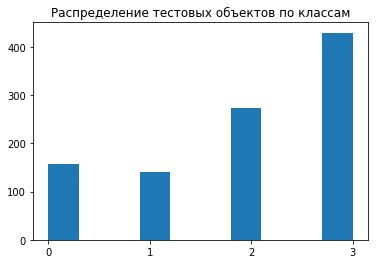

In [55]:
plt.title('Распределение тестовых объектов по классам')
plt.hist(submission['accuracy_group'])
plt.xticks([0, 1, 2, 3])
plt.show()

## Adversarial Validation


In [56]:
if ADVERSARIAL_VALIDATION and not IS_SUBMITTING:
    from sklearn.metrics import roc_auc_score
    from sklearn.model_selection import train_test_split

    av_clf = CatBoostClassifier(random_state = RANDOM_SEED,
                                loss_function = 'Logloss',
                                cat_features=categorical_features,
                                custom_metric='AUC',
                                eval_metric='AUC',
                                verbose=100,
                                metric_period=100,
                                num_trees=400)

    X_train = train.drop(columns=exclude_features)
    y_train = np.zeros(X_train.shape[0])
    X_test  = test.drop(columns=exclude_features)
    y_test  = np.ones(X_test.shape[0])

    X = pd.concat([X_train, X_test], axis=0)
    y = np.concatenate([y_train, y_test])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y, random_state=RANDOM_SEED)

    av_clf.fit(X_train, y_train)           

    av_roc_auc = roc_auc_score(y_test, av_clf.predict_proba(X_test)[:,1])

    if av_roc_auc < 0.6:
        print(f'AV ROC AUC {av_roc_auc:.3f}')
    else:
        print(f'AV ROC AUC {av_roc_auc:.3f} :::: WARNING!!! ')
        print('The most suspicious features are:')
        features = pd.DataFrame({'feature': X.columns, 'importance': av_clf.feature_importances_})
        features.sort_values(by=['importance'], ascending=False, inplace=True)
        for i in range(10):
            print(f'  {features.feature.iloc[i]}: {features.importance.iloc[i]:.4f}')

NameError: name 'ADVERSARIAL_VALIDATION' is not defined